In [ ]:
import numpy as np
np.random.seed(2)
import tensorflow as tf
tf.config.run_functions_eagerly(True)
#tf.enable_eager_execution()
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Conv1D

from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import backend as K
import uuid

In [ ]:
def add_pos_2(input,nb):
    input_pos_encoding = tf.constant(nb, shape=[input.shape[1]], dtype="int32")/input.shape[1]
    input_pos_encoding = tf.cast(tf.reshape(input_pos_encoding, [1,10]),tf.float32)
    input = tf.add(input ,input_pos_encoding)
    return input

def stack_block_transformer(num_transformer_blocks):
    input1 = keras.Input(shape=(100, 1))
    x = input1
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x,100,2)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    x = layers.Dense(10, activation='selu')(x)
    return input1,x

def stack_block_transformer_spatial(num_transformer_blocks,x):
  for _ in range(num_transformer_blocks):
      x = transformer_encoder(x,10*18,2)
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

  return x

def transformer_encoder(inputs,key_dim,num_heads):
    dropout=0.1
    # Normalization and Attention
    print("transformer_encoder",inputs.shape)
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=key_dim, num_heads=num_heads
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(key_dim, activation='softmax')(x)
    return x + res


def multiple_transformer(nb):
    '''

    :param nb: number of features ( indicates the number of parallel branches)
    :return:
    '''
    # initialise with the first input

    num_transformer_blocks = 2  #hyperparameter
    input_, transformer_ = stack_block_transformer(num_transformer_blocks)
    transformers = []
    inputs = []
    transformers.append(transformer_)
    inputs.append(input_)
    for i in range(1,nb ):
        input_i, transformer_i = stack_block_transformer(num_transformer_blocks)
        inputs.append(input_i) 
        transformer_i = add_pos_2(transformer_i,i)
        transformers.append(transformer_i)
  
    x = layers.concatenate(transformers, axis=-1)
    x = tf.expand_dims(x, -1) #-1 denotes the last dimension
    x = stack_block_transformer_spatial(num_transformer_blocks,x)
    x = Dropout(0.1)(x)
    x = layers.Dense(100, activation='selu')(x)
    x = Dropout(0.1)(x)
    x = layers.Dense(20, activation='selu')(x)
    x = Dropout(0.1)(x)
    answer = layers.Dense(1, activation='sigmoid')(x)
  
    model = Model(inputs, answer)
    opt = optimizers.RMSprop(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'],experimental_run_tf_function=False)
    print(model.summary())
    return model


def multiple_transformer_5_level(nb):
    '''
    Model for severity prediction , 5 classes output
    :param nb:  number of parallel branch
    :return:
    '''

  # initialise with the first input

    num_transformer_blocks = 2  #hyperparameter
    input_, transformer_ = stack_block_transformer(num_transformer_blocks)
    transformers = []
    inputs = []
    transformers.append(transformer_)
    inputs.append(input_)
    for i in range(1,nb ):
        input_i, transformer_i = stack_block_transformer(num_transformer_blocks)
        inputs.append(input_i)
        transformer_i = add_pos_2(transformer_i,i)
        transformers.append(transformer_i)
  
    x = layers.concatenate(transformers, axis=-1)
    x = tf.expand_dims(x, -1) #-1 denotes the last dimension
    x = stack_block_transformer_spatial(num_transformer_blocks,x)
    x = Dropout(0.1)(x)
    x = layers.Dense(100, activation='selu')(x)
    x = Dropout(0.1)(x)
    x = layers.Dense(20, activation='selu')(x)
    x = Dropout(0.1)(x)
    answer = layers.Dense(5, activation='sigmoid')(x)
  
    model = Model(inputs, answer)
    opt = optimizers.RMSprop(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'],experimental_run_tf_function=False)
    print(model.summary())
    return model

In [ ]:
import glob
import os
import random
import sys
from tensorflow import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
sys.path.append('/content/drive/MyDrive/Thesis/3rd_semester/Data/original')
np.random.seed(2)



class Data:

    def __init__(self,  input_data,  deep, gait_cycle, step=50, features=np.arange(1, 19), pk_level = True):
        '''

        :param load_or_get:  1: load data , 0: load preloaded datas ( npy)
        :param deep:  data in the format for deep learning algorithms
        :param gait_cycle: number of gait cycle per signal
        :param step: overlap between gait signals
        :param features: signals to be loaded ( coming from sensors)
        :param pk_level: if true , y is the parkinson level according
        '''

        self.deep = deep
        self.step = step
        self.nb_gait_cycle = gait_cycle


        self.features_to_load = features
        self.nb_features = self.features_to_load.shape[0]
        ###############
        self.X_data = np.array([])  # np.ones((self.nb_gait_cycle,self.nb_features))
        self.y_data = np.array([])
        self.nb_data_per_person = np.array([0])


        files = sorted(glob.glob(os.path.join(input_data, '*txt')))
        self.ctrl_list = []
        self.pk_list = []
        for file in files:

            if file.find(".txt") != -1:  # if control ("01.txt")
                if file.find("Co") != -1:  # if control
                    self.ctrl_list.append(file)
                elif file.find("Pt") != -1:  # if control
                    if pk_level:
                        if  file.find('SiPt02')!= -1:
                            pass
                        elif file.find('SiPt07')!= -1:
                            pass
                        else:
                            self.pk_list.append(file)
                    else :
                        self.pk_list.append(file)

        random.shuffle(self.ctrl_list)
        random.shuffle(self.pk_list)
        self.pk_level = pk_level
        if pk_level == True:
            self.levels = pd.read_csv( os.path.join(input_data, "demographics.csv"))
            self.levels.set_index('ID', inplace=True)
        self.load(norm=None)
     
    def add_pos(self,input):
       # Positional encoding
        input_pos_encoding = tf.range(input.shape[1])/input.shape[1]
        input_pos_encoding = tf.expand_dims(input_pos_encoding, -1)
        input_pos_encoding= tf.cast(tf.tile(input_pos_encoding, [1,input.shape[2]]),tf.float32)
        # Add the positional encoding
        input = input + input_pos_encoding
        return input


    def separate_fold(self, fold_number, total_fold=10):
        '''

        :param fold_number: Fold number
        :param total_fold: Total number of fols
        :return:
        '''
        proportion = 1 / total_fold  # .10 for 10 folds
        X = [self.X_ctrl, self.X_park]
        y = [self.y_ctrl, self.y_park]
        patients = [self.nb_data_per_person[:self.last_ctrl_patient], self.nb_data_per_person[self.last_ctrl_patient:]] # counts separated by classe
        patients[1]= patients[1] - patients[1][0]
        diff_count = np.diff(self.nb_data_per_person)
        diff_count = [diff_count[:self.last_ctrl_patient], diff_count[self.last_ctrl_patient:]]
        self.count_val = np.array([0])
        self.count_train = np.array([0])
        for i in range(len(X)):
            nbr_patients =  int(len(patients[i]) *proportion)
            start_patient = int(fold_number*nbr_patients )
            end_patient = (fold_number+1)*nbr_patients
            id_start = patients[i][start_patient]  # segment start
            id_end = patients[i][end_patient]  # end segment
            if i ==0 :
                self.X_val = X[i][id_start:id_end,:,:]
                self.X_train = np.delete(X[i], np.arange(id_start,id_end) , 0)

                self.y_val = y[i][id_start:id_end]
                self.y_train = np.delete(y[i], np.arange(id_start,id_end) , 0)


                self.count_val = np.append(self.count_val, diff_count[i][start_patient: end_patient])
                self.count_train = np.append(self.count_train, np.delete(diff_count[i], np.arange(start_patient, end_patient)))



            else:
                start_patient = start_patient #+ patients[0].shape[0]  # patients0.shape 0 is the number of patients in the first class
                end_patient =  end_patient# +patients[0].shape[0]
                self.X_val = np.vstack((self.X_val, X[i][id_start:id_end,:,:]))
                self.X_train = np.vstack((self.X_train, np.delete(X[i], np.arange(id_start,id_end) , 0) ))

                self.y_val = np.vstack((self.y_val, y[i][id_start:id_end] ))
                self.y_train = np.vstack((self.y_train, np.delete(y[i], np.arange(id_start,id_end) , 0) ))

                self.count_val = np.append( self.count_val , diff_count[i][start_patient: end_patient])
                self.count_train = np.append(self.count_train,np.delete(diff_count[i], np.arange(start_patient, end_patient)) )

        self.count_val = np.cumsum(self.count_val)
        self.count_train = np.cumsum(self.count_train )
        self.X_val = layers.LayerNormalization(epsilon=1e-6)(self.X_val)
        self.X_train = layers.LayerNormalization(epsilon=1e-6)(self.X_train)
        self.X_val = self.add_pos(self.X_val)
        self.X_train = self.add_pos(self.X_train)
      

    def load(self, norm = 'std'):
        print("load training control ")
        self.load_data(self.ctrl_list, 0)
        if self.deep == 1:
            self.last_ctrl= self.X_data.shape[2]
            self.last_ctrl_patient = len(self.nb_data_per_person)
        print("load training parkinson ")


        self.load_data(self.pk_list, 1)  # ncycle, nfeature, nombre de data


        ## all datas are loaded at this point, preprocessing now
        if self.deep == 1:
            self.X_data = self.X_data.transpose(2,0 , 1)  #0, 1

            if norm == 'std ':
                self.normalize()
            elif norm == 'l2':
                self.X_data = self.normalize_l2(self.X_data)

        if self.pk_level:
            self.one_hot_encoding()

        if self.deep == 1:
            self.X_ctrl = self.X_data[:self.last_ctrl]
            self.y_ctrl =  self.y_data[:self.last_ctrl]
            self.X_park = self.X_data[self.last_ctrl:]
            self.y_park = self.y_data[self.last_ctrl:]

        print("saving training ")
        np.save("Xdata", self.X_data)
        np.save("ydata", self.y_data)
        np.save('data_person',self.nb_data_per_person)
        np.save('ctrl_list', self.ctrl_list)
        np.save('pk_list', self.pk_list)

    def normalize(self):
        '''

        :return: Normalize to have a mean =  and std =1
        '''
        mean_train = np.mean(self.X_data,(0,1))
        std_train = np.std(self.X_data,(0,1))
        self.X_data= abs((self.X_data - mean_train) / std_train)
        #self.X_test= (self.X_test - mean_train) / std_train
    def one_hot_encoding(self):
        '''

        :return: return one hot encoding vector for severity prediction
        '''
        self.y_data[self.y_data<=4]=0
        self.y_data[(4<self.y_data) & (self.y_data <15)]=1
        self.y_data[(15<= self.y_data) & (self.y_data<25)]=2
        self.y_data[(25<= self.y_data) & (self.y_data<35)] = 3
        self.y_data[35<= self.y_data] = 4
        np.set_printoptions(threshold=sys.maxsize)
        # self.y_data = np.squeeze(self.y_data)
        #self.y_data = self.y_data[~np.isnan(self.y_data)] # Line 2
        self.y_data = np.nan_to_num(self.y_data)
        print(self.y_data)
        print(self.y_data.size)
        self.y_data = to_categorical(self.y_data)

    def normalize_l2(self, data):
        '''

        :param data:  Function to perform L2 normalization
        :return:
        '''
        data = keras.backend.l2_normalize(data, axis=(1, 2))
        data = tf.keras.backend.get_value(data)
        return data


    def load_data(self, liste, y):
        '''

        :param liste: list of patients filepaths
        :param y: 0 for control, 1 for parkinson
        :return:
        '''

        for i in range(0, len(liste)):
            datas = np.loadtxt(liste[i])  # num cycle, n features
            datas = datas[:, self.features_to_load]
            print(datas.shape[0])
            if  self.pk_level :
                print("1")
                y =self.find_level(liste[i])

            if self.deep == 1:
                print("2")
                X_data, y_data , self.nb_data_per_person = self.generate_datas(datas, y, self.nb_data_per_person)
              
            else:
                print("3")
                X_data, y_data = self.generate_datas_ml(datas, y)
            if (self.X_data).size == 0:
                print("4")
                self.X_data = X_data
                self.y_data = y_data
            else:
                print("5")
                if self.deep == 1:
                    print("6")
                    self.X_data = np.dstack((self.X_data, X_data))
                else:
                    print("7")
                    self.X_data = np.vstack((self.X_data, X_data))  # shape nb data --- vector size
                self.y_data = np.vstack((self.y_data, y_data))

            print(X_data.shape, self.X_data.shape,flush=True)
           


    def find_level(self,file):
        '''

        :param file: Dataframe
        :return:
        '''
        start = '/content/drive/MyDrive/Thesis/3rd_semester/Data/original/'
        end = '_'
        id = (file.split(start))[1].split(end)[0]
        y = self.levels.loc[id,'UPDRS']
        return y


    def generate_datas(self, datas, y, data_list):
        '''
        :param datas:  datas loaded for 1 patient
        :param y: label of the patient
        :param data_list: list containing the number of segments per patients
        :return:
        '''
        count = 0
        X_data = np.array([])
        y_data = np.array([])
        nb_datas = int(datas.shape[0] - self.nb_gait_cycle)
        for start in range(0, nb_datas, self.step):
            end = start + self.nb_gait_cycle
            data = datas[start:end, :]
            if X_data.size == 0:
                X_data = data
                y_data = y
            else:
                if (self.deep == 1):
                    X_data = np.dstack((X_data, data))
                else:
                    X_data = np.vstack((X_data, data))
                y_data = np.vstack((y_data, y))
            count = count + 1
        data_list = np.append(data_list, count+ data_list[-1])
        return X_data, y_data, data_list


    def get_datas(self):
        return self.X_data, self.y_data, self.X_test, self.y_test, self.X_val, self.y_val

In [ ]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix,  classification_report, accuracy_score
from scipy import stats
import pandas as pd
class Results:
    def __init__(self, filename_seg, filename_patient):
        '''

        :param filename_seg:  Filename  (.csv) where to save results at the segment levels
        :param filename_patient: Filename  (.csv) where to save results at the patient levels
        '''
        self.results_patients = np.zeros(3)
        self.results_segments = np.zeros(3)
        self.filename_seg = filename_seg
        self.filename_patient = filename_patient
    def add_result( self,res, accuracy,  segments = True  ):
        '''

        :param res: result of classification report (sklearn )
        :param accuracy:
        :param segments: 1 to add results at the segment level
        :return:
        '''
        if segments:
            specificity = res['0.0']['recall']
            sensitivy =  res['1.0']['recall']
        else:
            specificity = res['0']['recall']
            sensitivy =  res['1']['recall']
        all = np.array([specificity, sensitivy, accuracy])

        if segments:
            self.results_segments = np.vstack((self.results_segments, all))
        else:
            self.results_patients = np.vstack((self.results_patients, all ))

    def validate_patient(self, model, x_val, y_val, count):
        '''

        :param model: trained model after 1 fold of cross validation
        :param x_val: x_Val for 1 forld of cross validation
        :param y_val: y_Val for 1 forld of cross validation
        :param count: vector containing the number of segments per patient
        :return:  save the results of the fold

        '''
        ## per segments
        pred_seg = model.predict(np.split(x_val, x_val.shape[2], axis=2))
        res = classification_report(np.rint(y_val), np.rint(pred_seg), output_dict = True )
        acc = accuracy_score(np.rint(y_val), np.rint(pred_seg))
        self.add_result(res, acc,True  )

        eval = []
        y = []
        pred = []
        for m in range(1, len(count)):
            i = count[m]
            j = count[m - 1]
            score = model.evaluate(np.split(x_val[j:i, :, :], x_val.shape[2], axis=2), y_val[j:i])
            eval.append(score)
            y.append(np.int(np.mean(y_val[j:i])))
            p = np.rint(model.predict(np.split(x_val[j:i, :, :], x_val.shape[2], axis=2)))
            pred.append(np.mean(p))

        res = classification_report(y, np.rint(pred), output_dict = True )
        print(classification_report(y, np.rint(pred)))

        acc = accuracy_score(np.rint(y), np.rint(pred))
        self.add_result(res, acc, False )

        #np.savetxt(self.filename_patient, self.results_patients, delimiter=",")
        #np.savetxt(self.filename_seg, self.results_segments, delimiter=",")
        res_segments_dict = {'Specificity': self.results_segments[1:,0],'Sensitivity': self.results_segments[1:,1],'Accuracy': self.results_segments[1:,2]  }
        df = pd.DataFrame.from_dict(res_segments_dict)
        df.to_csv(self.filename_seg)
        res_patients_dict =  {'Specificity': self.results_patients[1:,0],'Sensitivity': self.results_patients[1:,1],'Accuracy': self.results_patients[1:,2]  }
        df = pd.DataFrame.from_dict(res_patients_dict)
        df.to_csv(self.filename_patient)



class Results_level:
    '''
    Class to save results for severity prediction
    '''
    def __init__(self, filename_seg, filename_patient, dir):
        '''

        :param filename_seg: filename (csv) where to save the results
        :param filename_patient:
        :param dir: directory where results files are saved
        '''
        self.results_patients = np.zeros(1)
        self.results_segments = np.zeros(1)
        self.filename_seg = filename_seg
        self.filename_patient = filename_patient
        self.gt = np.array([])
        self.pred = np.array([])
        self.dir = dir
    def add_result( self,res, accuracy,  segments = True  ):

        all = np.array([ accuracy])

        if segments:
            self.results_segments = np.vstack((self.results_segments, all))
        else:
            self.results_patients = np.vstack((self.results_patients, all ))



    def validate_patient(self, model, x_val, y_val, count):
        '''

        :param model: trained model after 1 fold of cross validation
        :param x_val: x_Val for 1 forld of cross validation
        :param y_val: y_Val for 1 forld of cross validation
        :param count: vector containing the number of segments per patient
        :return:  save the results of the fold

        '''
        ## per segments
        pred_seg = model.predict(np.split(x_val, x_val.shape[2], axis=2))
        res = classification_report(np.rint(y_val), np.rint(pred_seg), output_dict = True )
        acc = accuracy_score(np.rint(y_val), np.rint(pred_seg))
        self.add_result(res, acc,True  )

        eval = []
        y = []
        pred = []
        for m in range(1, len(count)):
            i = count[m]
            j = count[m - 1]
            score = model.evaluate(np.split(x_val[j:i, :, :], x_val.shape[2], axis=2), y_val[j:i])
            eval.append(score)
            y_gt = np.argmax(y_val[j:i],1)
            y_gt , _ = stats.mode(y_gt, axis = None)
            y.append(y_gt[0])
            p = np.rint(model.predict(np.split(x_val[j:i, :, :], x_val.shape[2], axis=2)))
            p = np.argmax(p, 1 )
            p, _ = stats.mode(p, axis=None)
            pred.append(p[0])

        res = classification_report(y, np.rint(pred), output_dict = True )
        print(classification_report(y, np.rint(pred)))
        self.gt = np.append(self.gt, y)
        self.pred = np.append(self.pred, np.rint(pred))
        acc = accuracy_score(np.rint(y), np.rint(pred))
        self.add_result(res, acc, False )
        res_segments_dict = {'Accuracy': self.results_segments[1:,0]}
        df = pd.DataFrame.from_dict(res_segments_dict)
        df.to_csv(self.filename_seg)
        res_patients_dict =  {'Accuracy': self.results_patients[1:,0]}
        df = pd.DataFrame.from_dict(res_patients_dict)
        df.to_csv(self.filename_patient)
        print(res)




    def write_results(self):
        '''
        Called at the end to write the final result files
        :return:
        '''
        res_segments_dict = {'Accuracy': self.results_segments[1:,0]}
        df = pd.DataFrame.from_dict(res_segments_dict)
        df.to_csv(self.filename_seg)
        res_patients_dict =  {'Accuracy': self.results_patients[1:,0]}
        df = pd.DataFrame.from_dict(res_patients_dict)
        df.to_csv(self.filename_patient)
        file_pred = os.path.join(self.dir, 'pred.csv')
        file_gt = os.path.join(self.dir, 'gt.csv')
        np.savetxt(file_pred, self.pred, delimiter="," )
        np.savetxt(file_gt,self.gt, delimiter=",")
        res = classification_report(self.gt, self.pred)
        print(res)
        self.cm = confusion_matrix(self.gt, self.pred)
        file_conf_matrx = os.path.join(self.dir, 'confusion_matrix.csv')
        np.savetxt(file_conf_matrx, self.cm, delimiter=",")

In [ ]:
import numpy as np
import argparse
# fix random seed for reproducibility
np.random.seed(2) #2
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import datetime
import os

#from src.data_utils2 import Datas
#from src.results import Results,Results_level

#from src.algo import multiple_cnn1D, multiple_cnn1D5_level
#from src.data_utils import Data

def train( model, datas, lr, log_filename, filename):
    """

    :param model: Initial untrained model
    :param datas:  data object
    :param lr: learning rate
    :param log_filename: filename where the training results will be saved ( for each epoch)
    :param filename: file where the weights will be saved
    :return:  trained model
    """
    X_train = datas.X_train
    y_train = datas.y_train
    X_val = datas.X_val
    y_val = datas.y_val
    
    
    logger = CSVLogger(log_filename, separator=',', append=True)
    for i in (np.arange(1,4)*5):  # 10-20    1-10

        checkpointer = ModelCheckpoint(filepath=filename , monitor='val_accuracy', verbose=1, save_best_only=True,save_freq='epoch')
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=0, mode='auto')

        callbacks_list = [checkpointer, early_stopping, logger]
        print("Y_train")
        print(len(y_train))
        history = model.fit(np.split(X_train,X_train.shape[2], axis=2), \
                            # history  = model.fit(X_data,\
                            y_train, \
                            verbose=1, \
                            shuffle=True, \
                            epochs= 100,\
                            batch_size=110, \
                            # validation_data=(X_val, y_val),\
                            validation_data=(np.split(X_val, X_val.shape[2], axis=2), y_val), \
                            callbacks=callbacks_list)

        model.load_weights(filename)
        lr =  lr / 2
        rms = optimizers.Nadam(lr=lr)
        model.compile(loss='binary_crossentropy', optimizer=rms, metrics=['accuracy'])
        return model


def train_classifier(args):
    '''
    Function that performs the detection of Parkinson
    :param args: Input arguments
    :return:
    '''
    exp_name = args.exp_name
    subfolder = os.path.join(args.output, exp_name +'_' + datetime.datetime.now().strftime("%m_%d"), datetime.datetime.now().strftime(
        "%H_%M"))
    file_result_patients = os.path.join(subfolder,'res_pat.csv')
    file_result_segments = os.path.join(subfolder,'res_seg.csv')
    model_file = os.path.join(subfolder, "model.json")
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)

    val_results = Results(file_result_segments, file_result_patients)
    datas = Data(args.input_data, 1, 100, pk_level= False )

    for i in range(0, 10):
        lr = 0.001
        model = multiple_transformer(datas.X_data.shape[2])
        model_json = model.to_json()
        with open(model_file, "w") as json_file:
            json_file.write(model_json)

        print('fold', str(i))
        datas.separate_fold(i)
        log_filename = os.path.join( subfolder ,"training_" + str(i) + ".csv")
        w_filename = os.path.join(subfolder ,"weights_" + str(i) + ".hdf5")
        model = train(model, datas, lr, log_filename, w_filename)
        print('Validation !!')
        val_results.validate_patient(model, datas.X_val, datas.y_val, datas.count_val)

def train_severity(args):
    '''

    :param args: Input arguments
    :return:
    '''
    features = np.arange(1, 19)


    exp_name = args.exp_name

    subfolder = os.path.join(args.output, exp_name +'_' + datetime.datetime.now().strftime("%m_%d"), datetime.datetime.now().strftime(
        "%H_%M"))
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)
    file_result_patients = os.path.join(subfolder ,'res_pat.csv')
    file_result_segments = os.path.join(subfolder ,'res_seg.csv')

    model_file = os.path.join(subfolder, "model.json")

    val_results = Results_level(file_result_segments, file_result_patients, subfolder )
    datas = Data(args.input_data, 1, 100)  # modif
    lr = 0.001
    for i in range(0,10):

        model = multiple_transformer_5_level(datas.X_data.shape[2])
        model_json = model.to_json()
        with open(model_file, "w") as json_file:
            json_file.write(model_json)
        print('fold', str(i))
        datas.separate_fold(i)
        log_filename = os.path.join(subfolder, "trainig" + str(i) + ".csv")
        w_filename = os.path.join(subfolder ,"weights_" + str(i) + ".hdf5")
        model = train(model, datas, lr, log_filename,  w_filename )
        print('Validation !!')
        val_results.validate_patient(model, datas.X_val, datas.y_val, datas.count_val)
        val_results.write_results()


if __name__ == '__main__':
    
    parser = argparse.ArgumentParser()
    parser.add_argument("-input_data", default='/content/drive/MyDrive/Thesis/3rd_semester/Data/original', type=str)
    #' 
    parser.add_argument("-exp_name", default='train_severity', type=str, help = 'train_classifier ; train_severity')
    parser.add_argument("-output", default='output', type=str)
    args = parser.parse_args(args=[])
    if not os.path.exists(args.output):
        os.makedirs(args.output)
    if args.exp_name == 'train_classifier' :
        train_classifier(args)
    if args.exp_name == 'train_severity':
        train_severity(args)

Streaming output truncated to the last 5000 lines.
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


 HeadAttention)                                                   'layer_normalization_44[0][0]'] 
                                                                                                  
 multi_head_attention_24 (Multi  (None, 100, 1)      1401        ['layer_normalization_48[0][0]', 
 HeadAttention)                                                   'layer_normalization_48[0][0]'] 
                                                                                                  
 multi_head_attention_26 (Multi  (None, 100, 1)      1401        ['layer_normalization_52[0][0]', 
 HeadAttention)                                                   'layer_normalization_52[0][0]'] 
                                                                                                  
 multi_head_attention_28 (Multi  (None, 100, 1)      1401        ['layer_normalization_56[0][0]', 
 HeadAttention)                                                   'layer_normalization_56[0][0]'] 
          

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
533/533 [==============================] - ETA: 0s - loss: 0.4130 - accuracy: 0.4766
Epoch 1: val_accuracy improved from -inf to 0.36880, saving model to output/train_severity_12_28/08_38/weights_0.hdf5
533/533 [==============================] - 695s 1s/step - loss: 0.4130 - accuracy: 0.4766 - val_loss: 0.4917 - val_accuracy: 0.3688
Epoch 2/100
533/533 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.6323
Epoch 2: val_accuracy improved from 0.36880 to 0.42500, saving model to output/train_severity_12_28/08_38/weights_0.hdf5
533/533 [==============================] - 682s 1s/step - loss: 0.3237 - accuracy: 0.6323 - val_loss: 0.4697 - val_accuracy: 0.4250
Epoch 3/100
533/533 [==============================] - ETA: 0s - loss: 0.2613 - accuracy: 0.7267
Epoch 3: val_accuracy improved from 0.42500 to 0.45573, saving model to output/train_severity_12_28/08_38/weights_0.hdf5
533/533 [==============================] - 675s 1s/step - loss: 0.2613 - accuracy: 0.

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Validation !!
214/214 [==============================] - 56s 264ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 [==============================] - 2s 261ms/step
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           2       0.50      1.00      0.67         2
           3       0.50      0.22      0.31         9
           4       0.75      0.90      0.82        10

    accuracy                           0.67        30
   macro avg       0.61      0.72      0.63        30
weighted avg       0.64      0.67      0.63        30

{'0': {'precision': 0.7, 'recall': 0.7777777777777778, 'f1-score': 0.7368421052631577, 'support': 9}, '2': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 2}, '3': {'precision': 0.5, 'recall': 0.2222222222222222, 'f1-score': 0.30769230769230765, 'support': 9}, '4': {'precision': 0.75, 'recall': 0.9, 'f1-score': 0.8181818181818182, 'support': 10}, 'accuracy': 0.6666666666666666, 'macro avg': {'precision': 0.6125, 'recall': 0.725, 'f1-score': 0.6323457244509876, 'support': 30}, 'w

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


 dropout_53 (Dropout)           (None, 100, 1)       0           ['multi_head_attention_50[0][0]']
                                                                                                  
 dropout_55 (Dropout)           (None, 100, 1)       0           ['multi_head_attention_52[0][0]']
                                                                                                  
 dropout_57 (Dropout)           (None, 100, 1)       0           ['multi_head_attention_54[0][0]']
                                                                                                  
 dropout_59 (Dropout)           (None, 100, 1)       0           ['multi_head_attention_56[0][0]']
                                                                                                  
 dropout_61 (Dropout)           (None, 100, 1)       0           ['multi_head_attention_58[0][0]']
                                                                                                  
 dropout_6

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
534/534 [==============================] - ETA: 0s - loss: 0.4214 - accuracy: 0.4612
Epoch 1: val_accuracy improved from -inf to 0.41246, saving model to output/train_severity_12_28/08_38/weights_1.hdf5
534/534 [==============================] - 667s 1s/step - loss: 0.4214 - accuracy: 0.4612 - val_loss: 0.4614 - val_accuracy: 0.4125
Epoch 2/100
534/534 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.6042
Epoch 2: val_accuracy improved from 0.41246 to 0.51288, saving model to output/train_severity_12_28/08_38/weights_1.hdf5
534/534 [==============================] - 677s 1s/step - loss: 0.3401 - accuracy: 0.6042 - val_loss: 0.4047 - val_accuracy: 0.5129
Epoch 3/100
534/534 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.6900
Epoch 3: val_accuracy improved from 0.51288 to 0.55544, saving model to output/train_severity_12_28/08_38/weights_1.hdf5
534/534 [==============================] - 665s 1s/step - loss: 0.2864 - accuracy: 0.

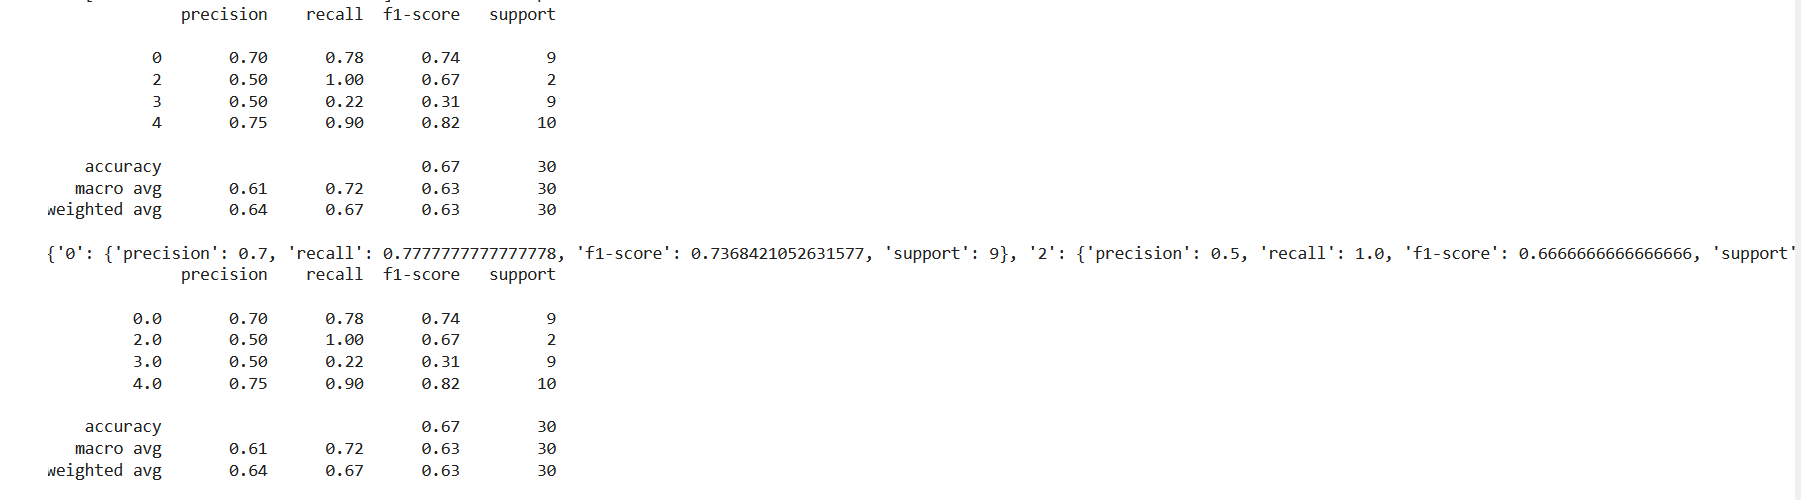

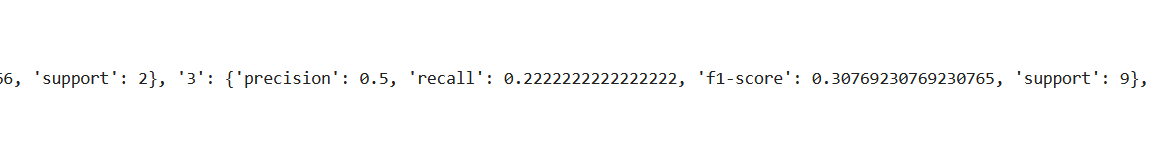

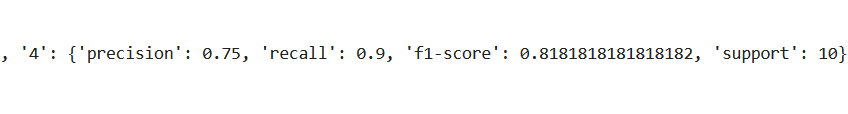

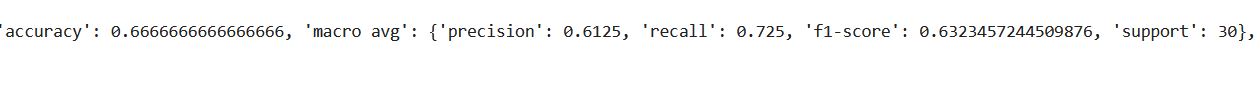

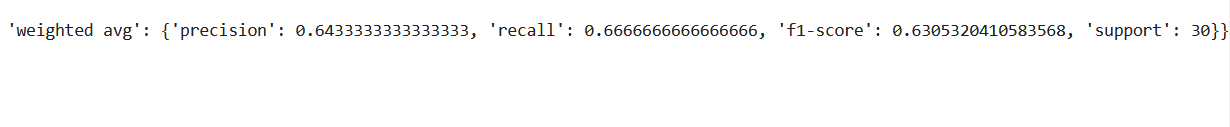